<a href="https://colab.research.google.com/github/pr3martins/PyLatheDB/blob/demo/demo/PyLatheDB_DEMO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyLatheDB - A Library for Relational Keyword Search with Support to Schema References
---






## Preparation Step

In [ ]:
# Install postgresql server
!sudo apt-get -y -qq update
!sudo apt-get -y -qq install postgresql postgresql-contrib &>log
!sudo service postgresql start

# Setup a password `postgres` for username `postgres`
!sudo -u postgres psql -U postgres -c "ALTER USER postgres PASSWORD 'postgres';"


 * Starting PostgreSQL 10 database server
   ...done.
ALTER ROLE


In [ ]:
!gdown --id 1KTRL-RhKgnzENlwcGHZ7zkvT4fVsQ1D7
!unzip PyLatheDB_DEMO_resources.zip
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
!cp dbsources/pylathedb.stop /usr/share/postgresql/10/tsearch_data/english.stop

Downloading...
From: https://drive.google.com/uc?id=1KTRL-RhKgnzENlwcGHZ7zkvT4fVsQ1D7
To: /content/PyLatheDB_DEMO_resources.zip
100% 92.3M/92.3M [00:00<00:00, 95.5MB/s]
Archive:  PyLatheDB_DEMO_resources.zip
   creating: datasets/
   creating: datasets/imdb/
  inflating: datasets/imdb/imdb_schema_index_file.shelve.db  
  inflating: datasets/imdb/imdb_schema_graph_file.pickle  
  inflating: datasets/imdb/imdb_value_index_file.shelve.db  
   creating: datasets/mondial/
  inflating: datasets/mondial/mondial_schema_graph_file.pickle  
  inflating: datasets/mondial/mondial_schema_index_file.shelve.db  
  inflating: datasets/mondial/mondial_value_index_file.shelve.db  
   creating: querysets/
  inflating: querysets/coffman_imdb.json  
  inflating: querysets/coffman_mondial.json  
   creating: dbsources/
  inflating: dbsources/mondial-schema_part2.pgsql  
  inflating: dbsources/imdb-schema.pgsql  
  inflating: dbsources/imdb-fulltext_index.psql  
  inflating: dbsources/imdb-data.pgsql  
  inf

In [ ]:
!sudo -u postgres psql -U postgres imdb

psql: FATAL:  database "imdb" does not exist


In [ ]:
SELECT EXISTS (
SELECT
	t1.name,
	t3.*
FROM
	person t1
	JOIN casting t2 ON t2.person_id = t1.id
	JOIN movie t3 ON t2.movie_id = t3.id
WHERE
	t1.name_tsvector @@ to_tsquery('roberts & julia')
LIMIT 1000);

SyntaxError: ignored

In [ ]:
!sudo -u postgres dropdb imdb
!sudo -u postgres createdb imdb
!sudo -u postgres psql -U postgres imdb <  dbsources/imdb-schema.pgsql
!sudo -u postgres psql -U postgres imdb <  dbsources/imdb-data.pgsql &>log
!sudo -u postgres psql -U postgres imdb <  dbsources/imdb-fulltext_index.psql
!sudo -u postgres psql -U postgres imdb < dbsources/imdb-rename-tables.psql

!sudo -u postgres dropdb mondial
!sudo -u postgres createdb mondial
!sudo -u postgres psql -U postgres mondial <  dbsources/mondial-schema_part1.pgsql
!sudo -u postgres psql -U postgres mondial <  dbsources/mondial-data.pgsql &>log
!sudo -u postgres psql -U postgres mondial <  dbsources/mondial-schema_part2.pgsql
!sudo -u postgres psql -U postgres mondial <  dbsources/mondial-field_fulltext_index.psql

In [ ]:
# pip install pylathedb==0.0.4.dev5 --no-cache-dir
# !pip uninstall pylathedb
!pip install -i https://test.pypi.org/simple/ pylathedb -U


In [ ]:
from google.colab import data_table
data_table.enable_dataframe_formatter()

## Configuration and Parameters

In [ ]:
from pylathedb.lathe import Lathe
lathe = Lathe(config_directory='./config/')
# lathe.create_indexes()

In [ ]:
lathe.change_queryset()

In [ ]:
lathe.change_queryset(2)

In [ ]:
lathe.load_indexes()

In [ ]:
lathe.max_qm_size = 3
lathe.max_cjn_size = 5
lathe.topk_cns = 10
lathe.configuration = (5,1,9)

## Keyword Search


query: will smith films


---

**1st CJN**:

---

Graph:


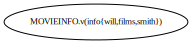

---

SQL:
  
  SELECT
  	t1.info
  FROM
  	movieinfo t1
  WHERE
  	t1.info_tsvector @@ to_tsquery('will & films & smith')
  LIMIT 1000;



---

JNTs:


,info
0,Ronald Fisher: Beer and pussy. That's all I ne...


---

**2nd CJN**:

---

Graph:


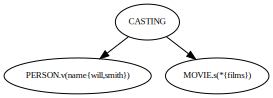

---

SQL:
  
  SELECT
  	t1.name,
  	t3.*
  FROM
  	person t1
  	JOIN casting t2 ON t2.person_id = t1.id
  	JOIN movie t3 ON t2.movie_id = t3.id
  WHERE
  	t1.name_tsvector @@ to_tsquery('will & smith')
  LIMIT 1000;



---

JNTs:


,name,id,title,imdb_index,kind_id,year,imdb_id,phonetic_code,episode_of_id,season_nr,episode_nr,series_years,__search_id
0,"Smith, Will",409179,Raw Hybrids,None,1,2008,None,R1632,None,None,None,None,44182670
1,"Smith, Will",560251,U (Unaccepted),None,1,2009,None,U5213,None,None,None,None,44281991
2,"Smith, Will",251689,Judgement Day,II,1,2010,None,J3253,None,None,None,None,43961583
3,"Smith, Will",182393,Free Enterprise,None,1,1998,None,F6536,None,None,None,None,43917381
4,"Smith, Will",235880,In the Loop,None,1,2009,None,I5341,None,None,None,None,44020524


---

**3rd CJN**:

---

Graph:


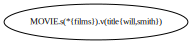

---

SQL:
  
  SELECT
  	t1.*,
  	t1.title
  FROM
  	movie t1
  WHERE
  	t1.title_tsvector @@ to_tsquery('will & smith')
  LIMIT 1000;



---

JNTs:


,id,title,imdb_index,kind_id,year,imdb_id,phonetic_code,episode_of_id,season_nr,episode_nr,series_years,__search_id,title
0,511163,The Last Will and Testament of Tom Smith,None,1,1943,None,L2345,None,None,None,None,44270314,The Last Will and Testament of Tom Smith
1,575829,Violent Will Smith,None,1,1997,None,V4534,None,None,None,None,44321388,Violent Will Smith
2,568074,Untitled Will Smith/Chef Jeff Project,None,1,2011,None,U5343,None,None,None,None,44301307,Untitled Will Smith/Chef Jeff Project


---

**4th CJN**:

---

Graph:


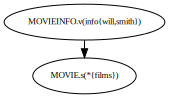

---

SQL:
  
  SELECT
  	t2.*,
  	t1.info
  FROM
  	movieinfo t1
  	JOIN movie t2 ON t1.movie_id = t2.id
  WHERE
  	t1.info_tsvector @@ to_tsquery('will & smith')
  LIMIT 1000;



---

JNTs:


,id,title,imdb_index,kind_id,year,imdb_id,phonetic_code,episode_of_id,season_nr,episode_nr,series_years,__search_id,info
0,340187,Mr. & Mrs. Smith,None,1,2005,None,M6562,None,None,None,None,44108441,"John Smith: Option A: You talk, we listen, no ..."
1,416391,Rising Sun,None,1,1993,None,R2525,None,None,None,None,44147608,John Connor: Every aspect of your appearance a...
2,443137,Shoot 'Em Up,None,1,2007,None,S351,None,None,None,None,44204431,Mr. Smith: I hate it when parents hit their ch...
3,544103,Three Texas Steers,None,1,1939,None,T6323,None,None,None,None,44238832,"Tucson Smith: Well, we're nearly home, boys.::..."
4,544103,Three Texas Steers,None,1,1939,None,T6323,None,None,None,None,44238832,Stony Brooke: We gotta figure out some way to ...


---

**5th CJN**:

---

Graph:


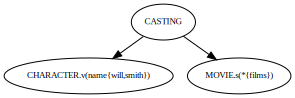

---

SQL:
  
  SELECT
  	t1.name,
  	t3.*
  FROM
  	character t1
  	JOIN casting t2 ON t2.person_role_id = t1.id
  	JOIN movie t3 ON t2.movie_id = t3.id
  WHERE
  	t1.name_tsvector @@ to_tsquery('will & smith')
  LIMIT 1000;



---

JNTs:


,name,id,title,imdb_index,kind_id,year,imdb_id,phonetic_code,episode_of_id,season_nr,episode_nr,series_years,__search_id
0,Will Smith,464015,Strange Adventures of Mr. Smith,None,1,1937,None,S3652,None,None,None,None,44205319


In [ ]:
results = lathe.keyword_search('will smith films')
results.cjns()

In [ ]:
results = lathe.keyword_search('john travolta olivia films')
results.qms()

query: john travolta olivia films


---

**1st QM**:

---

{PERSON.v(name{john,travolta}), MOVIE.s(*{films}), PERSON.v(name{john,olivia})}



---

**2nd QM**:

---

{CHARACTER.v(name{john,travolta}), MOVIE.s(*{films}), PERSON.v(name{john,olivia})}



---

**3rd QM**:

---

{PERSON.v(name{john,travolta}), PERSON.v(name{john,olivia}), MOVIEINFO.v(info{john,films})}



---

**4th QM**:

---

{PERSON.v(name{john,travolta}), MOVIE.s(*{films}), MOVIEINFO.v(info{john,olivia})}



---

**5th QM**:

---

{MOVIEINFO.v(info{john,travolta}), MOVIE.s(*{films}), PERSON.v(name{john,olivia})}



In [ ]:
lathe.keyword_search()

Please input a keyword query or choose one of the queries below:
01 - denzel washington
02 - clint eastwood
03 - john wayne
04 - will smith
05 - harrison ford
06 - julia roberts
07 - tom hanks
08 - johnny depp
09 - angelina jolie
10 - morgan freeman
11 - gone with the wind
12 - star wars
13 - casablanca
14 - lord of the rings
15 - the sound of music
16 - wizard of oz
17 - the notebook
18 - forrest gump
19 - the princess bride
20 - the godfather
21 - title atticus finch
22 - title indiana jones
23 - title james bond
24 - title rick blaine
25 - title will kane
26 - title dr. hannibal lecter
27 - title norman bates
28 - title darth vader
29 - title the wicked witch of the west
30 - title nurse ratched
31 - title frankly my dear i don't give a damn
32 - title i'm going to make him an offer he can't refuse
33 - title you don't understand i coulda had class i coulda been a contender i coulda been somebody instead of a bum which is what i am
34 - title toto i've a feeling we're not in kansas 

In [ ]:
lathe.configuration

(5, 1, 9)

In [ ]:
lathe.keyword_search()

Please input a keyword query or choose one of the queries below:
01 - denzel washington
02 - clint eastwood
03 - john wayne
04 - will smith
05 - harrison ford
06 - julia roberts
07 - tom hanks
08 - johnny depp
09 - angelina jolie
10 - morgan freeman
11 - gone with the wind
12 - star wars
13 - casablanca
14 - lord of the rings
15 - the sound of music
16 - wizard of oz
17 - the notebook
18 - forrest gump
19 - the princess bride
20 - the godfather
21 - title atticus finch
22 - title indiana jones
23 - title james bond
24 - title rick blaine
25 - title will kane
26 - title dr. hannibal lecter
27 - title norman bates
28 - title darth vader
29 - title the wicked witch of the west
30 - title nurse ratched
31 - title frankly my dear i don't give a damn
32 - title i'm going to make him an offer he can't refuse
33 - title you don't understand i coulda had class i coulda been a contender i coulda been somebody instead of a bum which is what i am
34 - title toto i've a feeling we're not in kansas 

query: julia roberts films


---

**1st CJN**:

---

Text:
	PERSON.v(name{roberts,julia})
		<CASTING
			>MOVIE.s(*{films})


---

Graph:


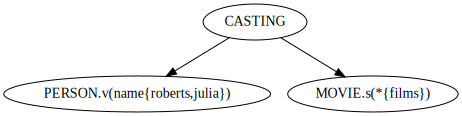

---

**2nd CJN**:

---

Text:
	MOVIE.s(*{films}).v(title{roberts,julia})


---

Graph:


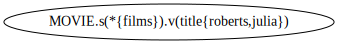

---

**3rd CJN**:

---

Text:
	MOVIEINFO.v(info{roberts,julia})
		>MOVIE.s(*{films})


---

Graph:


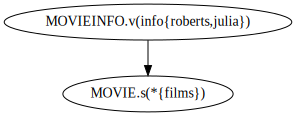

---

**4th CJN**:

---

Text:
	PERSON.v(name{julia})
		<CASTING
			>MOVIE.s(*{films})
				<CASTING
					>PERSON.v(name{roberts})


---

Graph:


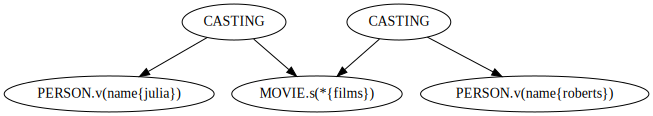

---

**5th CJN**:

---

Text:
	PERSON.v(name{roberts,julia})
		<CASTING
			>CHARACTER
				<CASTING
					>MOVIE.v(title{films})


---

Graph:


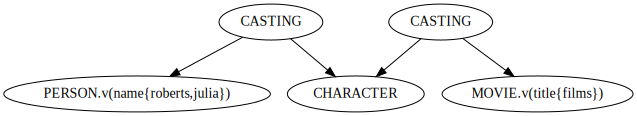

In [ ]:
results = lathe.keyword_search('julia roberts films')
results.cjns(show_graph=True,show_text=False,show_df=False)

query: john travolta olivia title


---

**1st CJN**:

---

Text:
	PERSON.v(name{travolta,john})
		<CASTING
			>MOVIE.s(title{title})
				<CASTING
					>PERSON.v(name{john,olivia})


---

Graph:


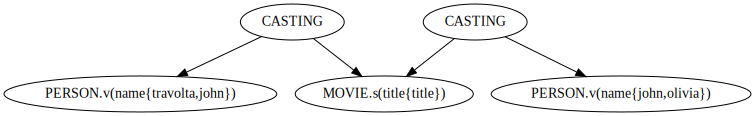

---

Results:


,name,title,name
0,"Travolta, John",Grease,"Newton-John, Olivia"
1,"Travolta, John",Two of a Kind,"Newton-John, Olivia"
2,"Travolta, John",The Guru,"Newton-John, Olivia"


---

**2nd CJN**:

---

Text:
	MOVIEINFO.v(info{travolta,john,olivia})
		>MOVIE.s(title{title})


---

Graph:


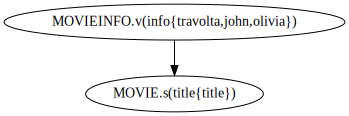

---

Results:


,title,info
0,The Last Days of Disco,Josh Neff: Disco will never be over. It will a...


In [ ]:
results = lathe.keyword_search('john travolta olivia title')
results.cjns(show_graph=True,show_df=True)

In [ ]:
results = lathe.keyword_search()

In [ ]:
results = lathe.keyword_search(38)

query: russell crowe gladiator char_name


In [ ]:
results.cjns(show_graph=True,show_df=True)

In [ ]:
results.cjns(show_str=True,
             show_graph=True,
             show_sql=False,
             show_df=True,
             )

In [ ]:
results.kms(top_k=5)

SKMs:
There is no SKM for this keyword query.


VKMs:
There is no VKM for this keyword query.


In [ ]:
results.qms()

1 QM:
{CHAR_NAME.s(*{char_name}).v(name{gladiator}), NAME.v(name{crowe,russell})}
--------------------------------------------------
2 QM:
{TITLE.v(title{gladiator}), NAME.v(name{crowe,russell}), CHAR_NAME.s(*{char_name})}
--------------------------------------------------
3 QM:
{CHAR_NAME.s(*{char_name}).v(name{gladiator}), MOVIE_INFO.v(info{crowe,russell})}
--------------------------------------------------
4 QM:
{TITLE.v(title{gladiator}), CHAR_NAME.s(*{char_name}), MOVIE_INFO.v(info{crowe,russell})}
--------------------------------------------------
5 QM:
{NAME.v(name{crowe,russell}), CHAR_NAME.s(*{char_name}), MOVIE_INFO.v(info{gladiator})}
--------------------------------------------------
6 QM:
{NAME.v(name{gladiator}), NAME.v(name{crowe,russell}), CHAR_NAME.s(*{char_name})}
--------------------------------------------------
7 QM:
{MOVIE_INFO.v(info{crowe,russell}), CHAR_NAME.s(*{char_name}), MOVIE_INFO.v(info{gladiator})}
--------------------------------------------------
8 QM: